In [2]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import  ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import EfficientNetV2S

In [3]:
# Cell 2: Define constants
BATCH_SIZE = 16
IMG_HEIGHT = 380   #efficientnetv2s
IMG_WIDTH = 380
# IMG_HEIGHT = 300 #EfficientNetV2B3
# IMG_WIDTH = 300
# IMG_HEIGHT = 528 #EfficientNetB6
# IMG_WIDTH = 528
DATA_DIR = "/home/anon/MajorProject/Data/asl"

In [5]:
# Cell 3: Load data

#train and test if already separated
# TRAIN_DATA_DIR = "/home/anon/MajorProject/Data/ASL_MAIN/asl_alphabet_train"
# TEST_DATA_DIR = "/home/anon/MajorProject/Data/Synthetic_Dataset/test"

# train_ds = tf.keras.utils.image_dataset_from_directory(
#     TRAIN_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     TEST_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)


train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 25291 files belonging to 36 classes.
Using 20233 files for training.
Found 25291 files belonging to 36 classes.
Using 5058 files for validation.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


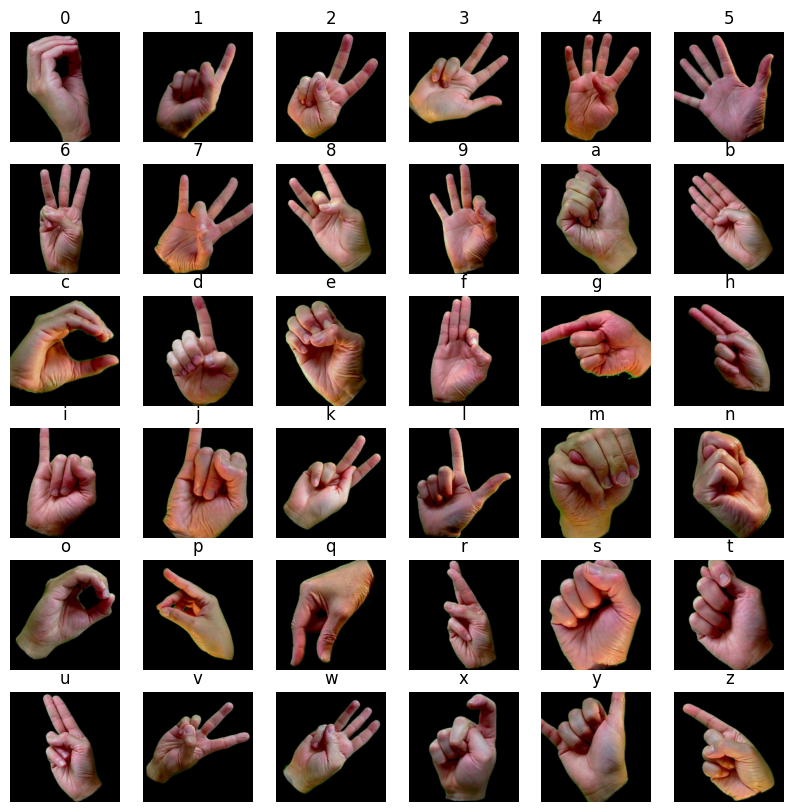

In [6]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Iterate over the images and labels in the current batch
  for image, label in zip(images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")



In [7]:
# Before data augmentation
for images, labels in train_ds.take(1):
  for image in images:
    print(image.shape)


(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)


In [9]:
# Cell 4: Define data augmentation
data_augmentation = keras.Sequential(
    [
        # layers.RandomFlip("horizontal"),
        # layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        # layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        # layers.RandomWidth(0.1),
        layers.RandomCrop(IMG_HEIGHT, IMG_HEIGHT),
    ]
)

In [10]:
# Cell 5: Preprocess data #data augmentation and one hot encoding
# train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))
# val_ds = val_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))


#no one hot encoding since class > 10:
# data augmentation
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y))
val_ds = val_ds.map(lambda x, y: (x, y))

In [11]:
# After data augmentation
for images, labels in train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y)).take(1):
    for image in images:
        print(image.shape)

(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)
(380, 380, 3)


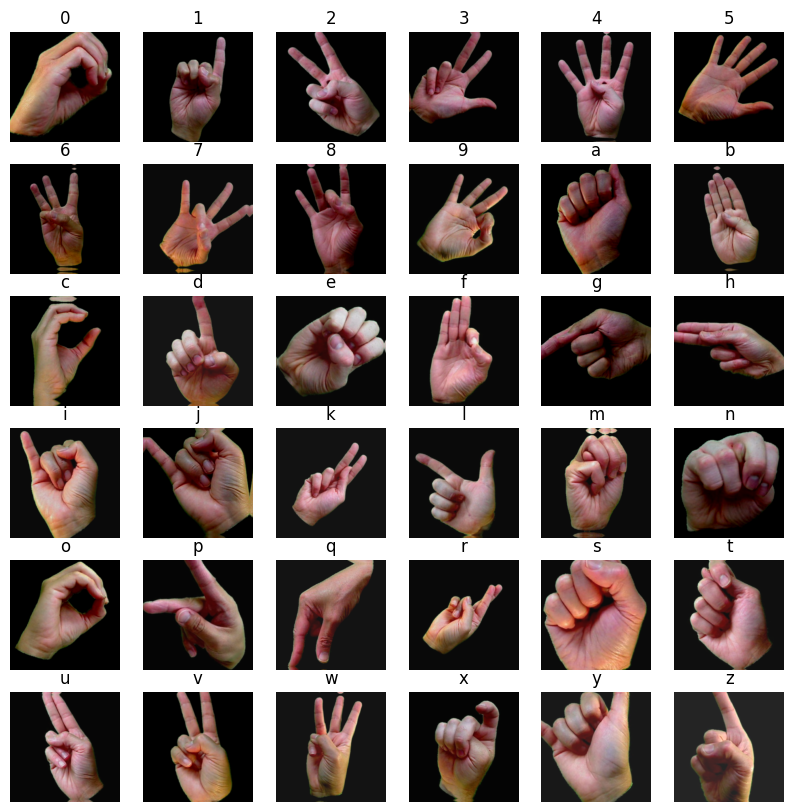

In [12]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Apply data augmentation
  augmented_images = tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), images)
  
  # Iterate over the images and labels in the current batch
  for image, label in zip(augmented_images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")


In [18]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = EfficientNetV2S(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.5
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)  # Removed L2 regularization

# Compile
model = keras.Model(inputs, outputs, name="EfficientNet")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

In [19]:
for images, labels in train_ds.take(1):
    print(f'Training images shape: {images.shape}, labels shape: {labels.shape}')

for images, labels in val_ds.take(1):
    print(f'Validation images shape: {images.shape}, labels shape: {labels.shape}')


Training images shape: (16, 380, 380, 3), labels shape: (16,)
Validation images shape: (16, 380, 380, 3), labels shape: (16,)


In [16]:
print(model.summary())

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 380, 380, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 380, 380, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 190, 190, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 190, 190, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                    

In [20]:
# Cell 7: Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_filepath = '/home/anon/MajorProject/Non_Git/Checkpoints/asl/checkpoint-{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

In [22]:
#Cell 8 train the model
epochs = 30
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint])
# hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/30
1265/1265 [==============================] - 78s 61ms/step - loss: 1.0812 - accuracy: 0.7757 - sparse_categorical_accuracy: 0.7757 - sparse_top_k_categorical_accuracy: 0.9818 - val_loss: 0.6871 - val_accuracy: 0.9199 - val_sparse_categorical_accuracy: 0.9199 - val_sparse_top_k_categorical_accuracy: 0.9998
Epoch 2/30
1265/1265 [==============================] - 77s 61ms/step - loss: 1.0804 - accuracy: 0.7740 - sparse_categorical_accuracy: 0.7740 - sparse_top_k_categorical_accuracy: 0.9820 - val_loss: 0.7122 - val_accuracy: 0.9023 - val_sparse_categorical_accuracy: 0.9023 - val_sparse_top_k_categorical_accuracy: 0.9964
Epoch 3/30
1265/1265 [==============================] - 77s 61ms/step - loss: 1.0791 - accuracy: 0.7714 - sparse_categorical_accuracy: 0.7714 - sparse_top_k_categorical_accuracy: 0.9813 - val_loss: 0.6524 - val_accuracy: 0.9330 - val_sparse_categorical_accuracy: 0.9330 - val_sparse_top_k_categorical_accuracy: 0.9996
Epoch 4/30
1265/1265 [========================

2024-02-16 18:31:18.927077: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 27724864 bytes after encountering the first element of size 27724864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1265/1265 [==============================] - 78s 62ms/step - loss: 1.0215 - accuracy: 0.7792 - sparse_categorical_accuracy: 0.7792 - sparse_top_k_categorical_accuracy: 0.9829 - val_loss: 0.5874 - val_accuracy: 0.9348 - val_sparse_categorical_accuracy: 0.9348 - val_sparse_top_k_categorical_accuracy: 0.9996
Epoch 13/30
   3/1265 [..............................] - ETA: 1:08 - loss: 1.0873 - accuracy: 0.7708 - sparse_categorical_accuracy: 0.7708 - sparse_top_k_categorical_accuracy: 0.9583

2024-02-16 18:32:36.987088: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 27724864 bytes after encountering the first element of size 27724864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1265/1265 [==============================] - 78s 62ms/step - loss: 0.9979 - accuracy: 0.7871 - sparse_categorical_accuracy: 0.7871 - sparse_top_k_categorical_accuracy: 0.9832 - val_loss: 0.5930 - val_accuracy: 0.9340 - val_sparse_categorical_accuracy: 0.9340 - val_sparse_top_k_categorical_accuracy: 0.9992
Epoch 14/30
   3/1265 [..............................] - ETA: 1:06 - loss: 1.0123 - accuracy: 0.7083 - sparse_categorical_accuracy: 0.7083 - sparse_top_k_categorical_accuracy: 1.0000

2024-02-16 18:33:55.050806: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 27724864 bytes after encountering the first element of size 27724864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1265/1265 [==============================] - 79s 63ms/step - loss: 0.9875 - accuracy: 0.7845 - sparse_categorical_accuracy: 0.7845 - sparse_top_k_categorical_accuracy: 0.9852 - val_loss: 0.6119 - val_accuracy: 0.9270 - val_sparse_categorical_accuracy: 0.9270 - val_sparse_top_k_categorical_accuracy: 0.9996
Epoch 15/30
   3/1265 [..............................] - ETA: 1:15 - loss: 0.8807 - accuracy: 0.8333 - sparse_categorical_accuracy: 0.8333 - sparse_top_k_categorical_accuracy: 0.9792

2024-02-16 18:35:14.547972: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 27724864 bytes after encountering the first element of size 27724864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1265/1265 [==============================] - 79s 62ms/step - loss: 0.9770 - accuracy: 0.7877 - sparse_categorical_accuracy: 0.7877 - sparse_top_k_categorical_accuracy: 0.9853 - val_loss: 0.6048 - val_accuracy: 0.9237 - val_sparse_categorical_accuracy: 0.9237 - val_sparse_top_k_categorical_accuracy: 0.9988


In [23]:
# Cell 10: Save the model
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2S_380x380_FEB_16_asl_droprate_0.5_yes_l2_reg.h5')

In [24]:
#for categorical_crossentropy
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)


#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 19ms/step


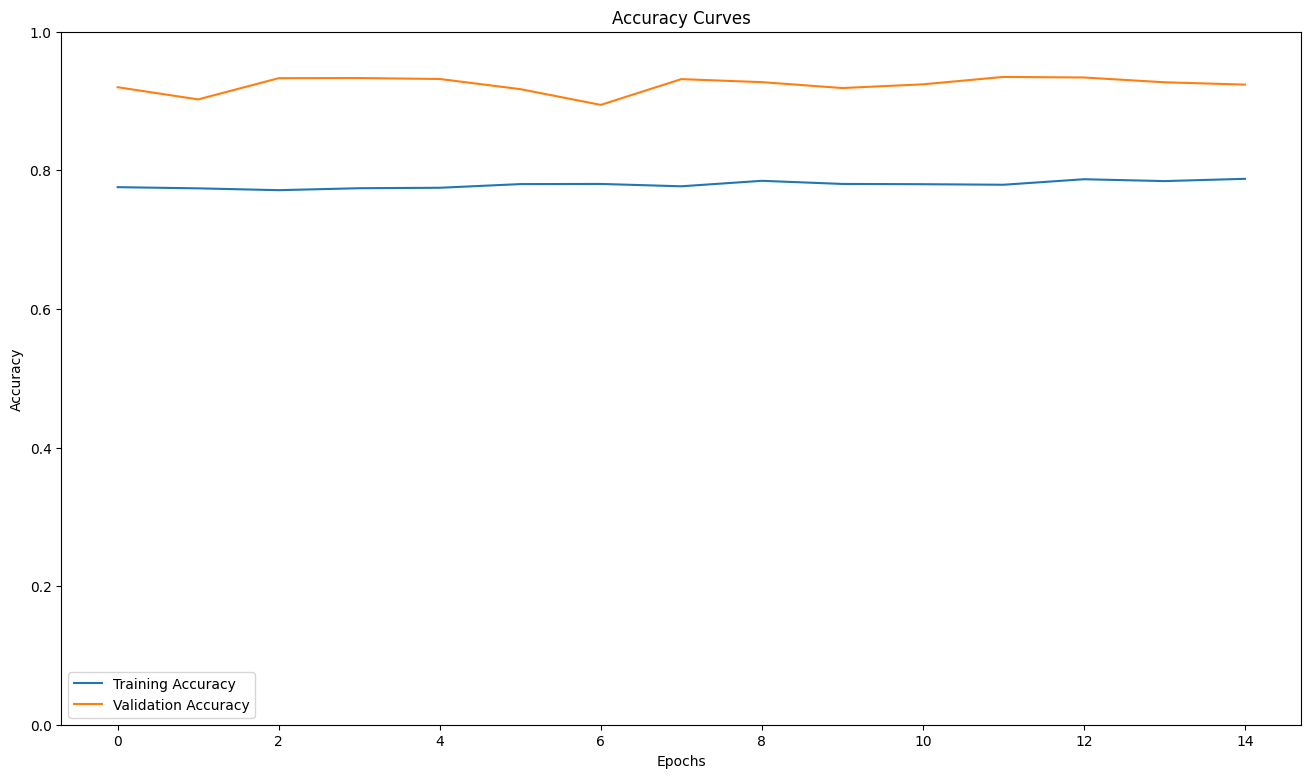

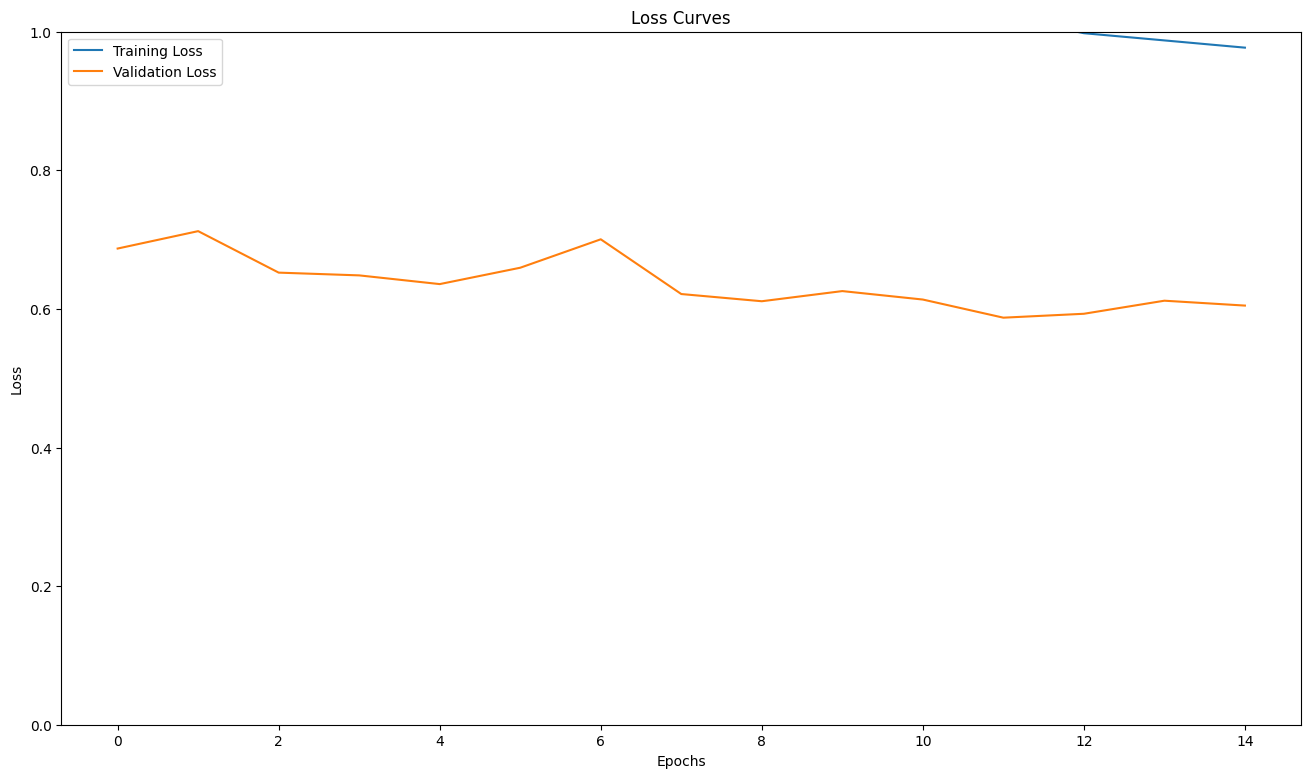

In [25]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[16,9])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[16,9])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()


In [37]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_2
1 rescaling_1
2 stem_conv
3 stem_bn
4 stem_activation
5 block1a_project_conv
6 block1a_project_bn
7 block1a_project_activation
8 block1a_add
9 block1b_project_conv
10 block1b_project_bn
11 block1b_project_activation
12 block1b_drop
13 block1b_add
14 block2a_expand_conv
15 block2a_expand_bn
16 block2a_expand_activation
17 block2a_project_conv
18 block2a_project_bn
19 block2b_expand_conv
20 block2b_expand_bn
21 block2b_expand_activation
22 block2b_project_conv
23 block2b_project_bn
24 block2b_drop
25 block2b_add
26 block2c_expand_conv
27 block2c_expand_bn
28 block2c_expand_activation
29 block2c_project_conv
30 block2c_project_bn
31 block2c_drop
32 block2c_add
33 block2d_expand_conv
34 block2d_expand_bn
35 block2d_expand_activation
36 block2d_project_conv
37 block2d_project_bn
38 block2d_drop
39 block2d_add
40 block3a_expand_conv
41 block3a_expand_bn
42 block3a_expand_activation
43 block3a_project_conv
44 block3a_project_bn
45 block3b_expand_conv
46 block3b_expand_bn
47 block3b_

In [28]:
# Cell 9: Unfreeze model and continue training
# for layer in model.layers[-20:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

# # we chose to train the top 2 blocks, i.e. we will freeze
# # the first xxx layers and unfreeze the rest:
# for layer in model.layers[:514]:
#    layer.trainable = False
# for layer in model.layers[514:]:
#    layer.trainable = True
# # we need to recompile the model for these modifications to take effect
# # we train our model again (this time fine-tuning the top 2 blocks
# # alongside the top Dense layers
# optimizer = keras.optimizers.Adam(learning_rate=1e-5)
# model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

# epochs = 5
# hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

for layer in model.layers[:514]:
   layer.trainable = False
for layer in model.layers[514:]:
   if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

epochs = 10
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/10
1265/1265 [==============================] - 89s 63ms/step - loss: 0.9887 - accuracy: 0.7870 - sparse_categorical_accuracy: 0.7870 - sparse_top_k_categorical_accuracy: 0.9840 - val_loss: 0.5801 - val_accuracy: 0.9377 - val_sparse_categorical_accuracy: 0.9377 - val_sparse_top_k_categorical_accuracy: 0.9996
Epoch 2/10
1265/1265 [==============================] - 77s 61ms/step - loss: 0.9843 - accuracy: 0.7860 - sparse_categorical_accuracy: 0.7860 - sparse_top_k_categorical_accuracy: 0.9842 - val_loss: 0.5805 - val_accuracy: 0.9375 - val_sparse_categorical_accuracy: 0.9375 - val_sparse_top_k_categorical_accuracy: 0.9996
Epoch 3/10
   4/1265 [..............................] - ETA: 1:06 - loss: 1.0661 - accuracy: 0.7500 - sparse_categorical_accuracy: 0.7500 - sparse_top_k_categorical_accuracy: 0.9844

2024-02-16 18:46:32.881866: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 27724864 bytes after encountering the first element of size 27724864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1265/1265 [==============================] - 78s 61ms/step - loss: 0.9664 - accuracy: 0.7936 - sparse_categorical_accuracy: 0.7936 - sparse_top_k_categorical_accuracy: 0.9857 - val_loss: 0.5758 - val_accuracy: 0.9405 - val_sparse_categorical_accuracy: 0.9405 - val_sparse_top_k_categorical_accuracy: 0.9996
Epoch 4/10
   3/1265 [..............................] - ETA: 1:06 - loss: 1.0198 - accuracy: 0.7083 - sparse_categorical_accuracy: 0.7083 - sparse_top_k_categorical_accuracy: 1.0000

2024-02-16 18:47:50.492663: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 27724864 bytes after encountering the first element of size 27724864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1265/1265 [==============================] - 78s 61ms/step - loss: 0.9639 - accuracy: 0.7925 - sparse_categorical_accuracy: 0.7925 - sparse_top_k_categorical_accuracy: 0.9861 - val_loss: 0.5719 - val_accuracy: 0.9425 - val_sparse_categorical_accuracy: 0.9425 - val_sparse_top_k_categorical_accuracy: 0.9996
Epoch 5/10
1265/1265 [==============================] - 78s 61ms/step - loss: 0.9529 - accuracy: 0.7990 - sparse_categorical_accuracy: 0.7990 - sparse_top_k_categorical_accuracy: 0.9862 - val_loss: 0.5685 - val_accuracy: 0.9433 - val_sparse_categorical_accuracy: 0.9433 - val_sparse_top_k_categorical_accuracy: 0.9998
Epoch 6/10
1265/1265 [==============================] - 80s 63ms/step - loss: 0.9494 - accuracy: 0.8005 - sparse_categorical_accuracy: 0.8005 - sparse_top_k_categorical_accuracy: 0.9875 - val_loss: 0.5683 - val_accuracy: 0.9437 - val_sparse_categorical_accuracy: 0.9437 - val_sparse_top_k_categorical_accuracy: 0.9996
Epoch 7/10
1265/1265 [==============================] - 7

2024-02-16 18:55:40.838348: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 27724864 bytes after encountering the first element of size 27724864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1265/1265 [==============================] - 79s 62ms/step - loss: 0.9388 - accuracy: 0.8042 - sparse_categorical_accuracy: 0.8042 - sparse_top_k_categorical_accuracy: 0.9865 - val_loss: 0.5590 - val_accuracy: 0.9510 - val_sparse_categorical_accuracy: 0.9510 - val_sparse_top_k_categorical_accuracy: 0.9998


In [29]:
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 26ms/step


Accuracy: 0.9509687623566627
Precision: 0.954340932041171
Recall: 0.9521326156051434
F1 Score: 0.9512781719759129
AUC-ROC: 0.9753657128126593


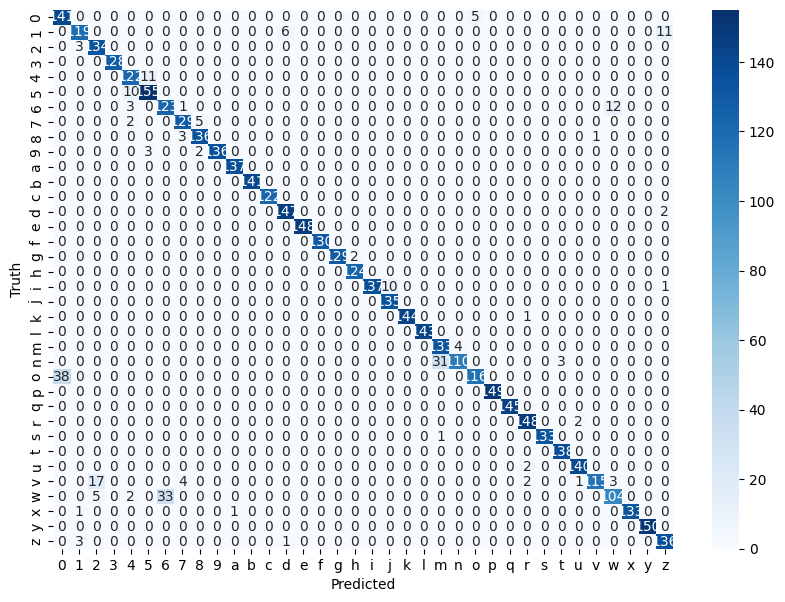

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score
average = 'macro'  # or 'micro', 'weighted', depending on the problem
precision = precision_score(y_true, y_pred, average=average)
recall = recall_score(y_true, y_pred, average=average)
f1 = f1_score(y_true, y_pred, average=average)

# AUC-ROC for multiclass
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

# Assuming class_names is a list of your class names in the order they were encoded
# class_names = ['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Initiation', 'Left_Click', 'Neutral', 'Nothing', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'Volume_Decrease', 'Volume_Increase']
# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# class_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Convert the true and predicted labels to a binary matrix
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)
y_pred_bin = lb.transform(y_pred)

# Calculate the macro-averaged AUC-ROC
auc_roc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC-ROC: {auc_roc_macro}")


Macro-Averaged AUC-ROC: 0.9753657128126593


In [34]:
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2S_380x380_FEB_16_asl_mix_droprate_0.5_yes_l2_reg_finetuned.h5')

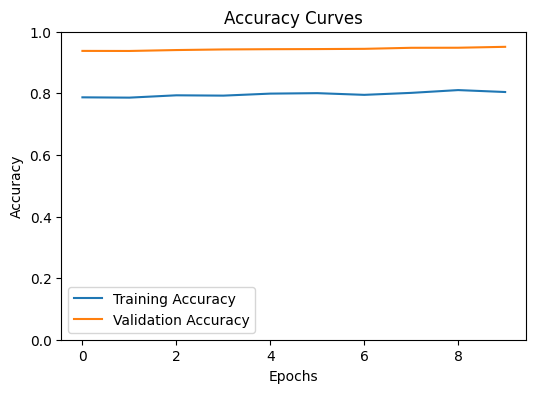

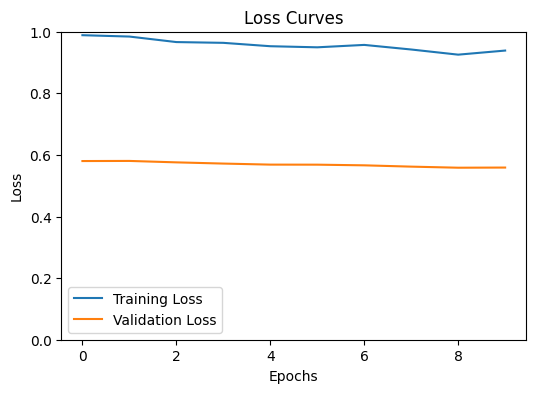

In [35]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
